ROC-AUC: 0.8779 (95% CI: 0.8428, 0.9290)
PR-AUC: 0.6227
F1 Score: 0.5957
Matthews CC: 0.5052


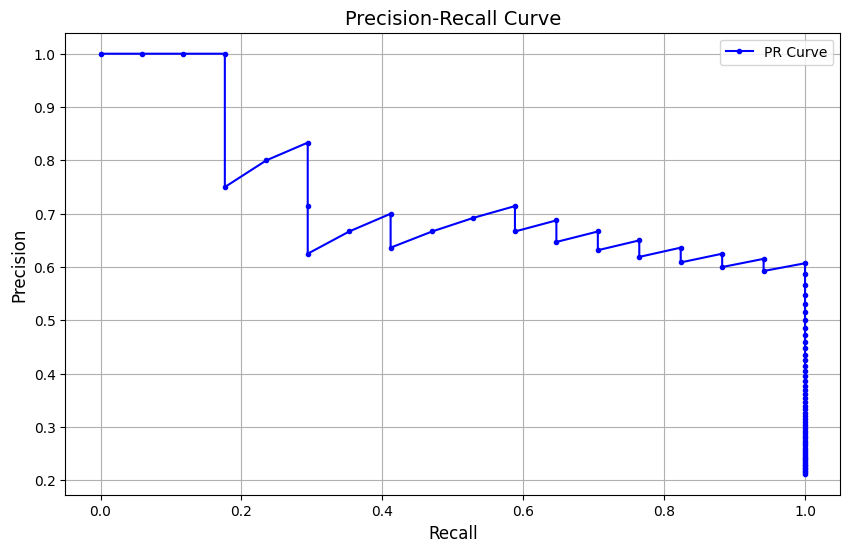

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, f1_score, matthews_corrcoef
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


%run dataInfo.ipynb
cleanTest = test_df
cleanTrain = train_df #doesn't have asd/class

# Features (X) and target (y)
X = cleanTrain.drop(columns=['Class/ASD'])  # Drop target variable from features
y = cleanTrain['Class/ASD']  # Target variable

# Test set (cleanTest) doesn't have the target variable, so we exclude it from features
X_test = cleanTest.drop(columns=['Class/ASD'])  # Drop target variable from features

from sklearn.impute import SimpleImputer

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Replace missing values with the mean
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

smote = SMOTE(random_state=42)  # Initialize SMOTE

n_splits = 10  # Stratified K-Fold CV splits
n_repeats = 3  # Repeat CV for 3 times
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=1,  # Handle imbalance through class weight
    random_state=42
)

roc_auc_scores = []
pr_auc_scores = []
f1_scores = []
mcc_scores = []

for repeat in range(n_repeats):
    for train_index, val_index in skf.split(X, y):
        # Split data into training and validation
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Apply SMOTE to training data
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        
        # Fit the XGBoost model
        xgb_model.fit(X_train_res, y_train_res)
        
        # Predict probabilities for ROC-AUC and PR-AUC
        y_prob = xgb_model.predict_proba(X_val)[:, 1]
        
        # Calculate metrics
        roc_auc = roc_auc_score(y_val, y_prob)
        pr_auc = average_precision_score(y_val, y_prob)
        f1 = f1_score(y_val, xgb_model.predict(X_val))
        mcc = matthews_corrcoef(y_val, xgb_model.predict(X_val))
        
        # Store the results
        roc_auc_scores.append(roc_auc)
        pr_auc_scores.append(pr_auc)
        f1_scores.append(f1)
        mcc_scores.append(mcc)

# 2. Calculate mean and CI for ROC-AUC and other metrics
roc_auc_mean = np.mean(roc_auc_scores)
roc_auc_ci = np.percentile(roc_auc_scores, [2.5, 97.5])

pr_auc_mean = np.mean(pr_auc_scores)
f1_mean = np.mean(f1_scores)
mcc_mean = np.mean(mcc_scores)

print(f"ROC-AUC: {roc_auc_mean:.4f} (95% CI: {roc_auc_ci[0]:.4f}, {roc_auc_ci[1]:.4f})")
print(f"PR-AUC: {pr_auc_mean:.4f}")
print(f"F1 Score: {f1_mean:.4f}")
print(f"Matthews CC: {mcc_mean:.4f}")


# Optionally, plot the PR Curve for the final model
# Get precision-recall curve values
precision, recall, _ = precision_recall_curve(y_val, y_prob)

# Plot PR Curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', color='b', label='PR Curve')

# Add labels and title
plt.title('Precision-Recall Curve', fontsize=14)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)

# Show plot
plt.legend()
plt.grid(True)
plt.show()